In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import backend as K
import random

In [2]:

np.random.seed(2321817) 
#
random.seed(2321817)


tf.random.set_seed(2321817)

K.clear_session() # Set seed for Keras

In [3]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# Normalize and reshape data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [5]:
print(x_train.shape)
print(x_test.shape)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
# Define client functions
def create_client_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_client_model(model, x_train, y_train, epochs=5):
    model.fit(x_train, y_train, epochs=epochs, 
              #verbose=0,
             verbose=1)
    return model

In [7]:
# Split data into two clients
x_train_c1, x_train_c2, y_train_c1, y_train_c2 = train_test_split(x_train, y_train, test_size=0.5, 
                                                                  #random_state=42,
                                                  # Put your SID instead of number '42'                
                                                                  random_state= 2167288
                                                                 )

In [8]:
print(x_train_c1.shape)
print(x_train_c2.shape)
print(y_train_c1.shape)
print(y_train_c2.shape)

(30000, 28, 28, 1)
(30000, 28, 28, 1)
(30000,)
(30000,)


In [9]:
# Create and train client models

client1_model = create_client_model()
client2_model = create_client_model()

client1_model = train_client_model(client1_model, x_train_c1, y_train_c1)
client2_model = train_client_model(client2_model, x_train_c2, y_train_c2)


Epoch 1/5


938/938 [==============================] - 8s 6ms/step - loss: 0.3503 - accuracy: 0.9001
Epoch 2/5
938/938 [==============================] - 6s 6ms/step - loss: 0.1640 - accuracy: 0.9518
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 0.1134 - accuracy: 0.9670
Epoch 4/5
938/938 [==============================] - 6s 7ms/step - loss: 0.0817 - accuracy: 0.9762
Epoch 5/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0622 - accuracy: 0.9819
Epoch 1/5
938/938 [==============================] - 7s 5ms/step - loss: 0.3368 - accuracy: 0.9048
Epoch 2/5
938/938 [==============================] - 5s 5ms/step - loss: 0.1606 - accuracy: 0.9541
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 0.1114 - accuracy: 0.9685
Epoch 4/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0830 - accuracy: 0.9760
Epoch 5/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0631 - accuracy: 0.9815


In [10]:
# Federated averaging

def federated_average_weights(weights1, weights2):
    new_weights = []
    for w1, w2 in zip(weights1, weights2):
        new_weights.append((w1 + w2) / 2)
    return new_weights

In [11]:
# Aggregate models

aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights())

In [12]:
# Create global model and set weights

global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [13]:
# Evaluate global model

test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 2s - loss: 0.3876 - accuracy: 0.8890 - 2s/epoch - 7ms/step
Test accuracy: 0.8889999985694885


In [14]:
test_accuracy = []

In [15]:
test_accuracy.append(0.8851000070571899)

In [16]:
test_accuracy

[0.8851000070571899]

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [18]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 2s 4ms/step
(10000, 10)


In [19]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       980
           1       1.00      0.74      0.85      1135
           2       0.80      0.97      0.87      1032
           3       0.87      0.93      0.90      1010
           4       0.92      0.95      0.93       982
           5       0.93      0.89      0.91       892
           6       0.97      0.95      0.96       958
           7       0.83      0.96      0.89      1028
           8       0.72      0.85      0.78       974
           9       0.99      0.76      0.86      1009

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



In [20]:
print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

Accuracy test set:  0.889
Precision test set:  0.9014703289389777
Recall test set:  0.889
F-score test set:  0.8894569339909256


In [21]:
test_precision = []
test_recall    = []
test_f1_score  = []

In [22]:
test_precision.append(0.907323157047967)
test_recall.append(0.8851)
test_f1_score.append(0.8851514824563385)

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

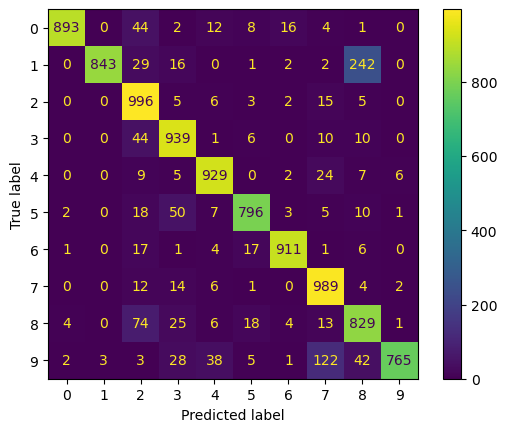

In [24]:
# display confusion matrix between test output and predicted output

cm = confusion_matrix(y_test, predictions) 
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot();
#plt.show()

# 4 Clients

In [25]:
Client_1 = (x_train[0:15000], y_train[0:15000])
Client_2 = (x_train[15000:30000], y_train[15000:30000])
Client_3 = (x_train[30000:45000], y_train[30000:45000])
Client_4 = (x_train[45000:], y_train[45000:])

In [26]:
print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)

(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000,)
(15000,)
(15000,)
(15000,)


In [27]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])

Epoch 1/5
469/469 [==============================] - 3s 3ms/step - loss: 0.4476 - accuracy: 0.8756
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.2106 - accuracy: 0.9397
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1489 - accuracy: 0.9566
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1091 - accuracy: 0.9686
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0836 - accuracy: 0.9771
Epoch 1/5
469/469 [==============================] - 2s 2ms/step - loss: 2.3117 - accuracy: 0.1032
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2969 - accuracy: 0.1157
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2864 - accuracy: 0.1311
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2707 - accuracy: 0.1456
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2500 - accuracy: 0.1523
Epoch 1/5


In [28]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4):
    new_weights = []
    for w1, w2, w3, w4 in zip(weights1, weights2, weights3, weights4):
        new_weights.append((w1 + w2 + w3 + w4) / 4)
    return new_weights


In [29]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [30]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 0s - loss: 2.2366 - accuracy: 0.2875 - 482ms/epoch - 2ms/step
Test accuracy: 0.2874999940395355


In [31]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 0s 860us/step
(10000, 10)


In [32]:
print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

Accuracy test set:  0.2875
Precision test set:  0.3593760627430135
Recall test set:  0.2875
F-score test set:  0.2666151434259582
              precision    recall  f1-score   support

           0       0.47      0.20      0.28       980
           1       0.16      0.25      0.20      1135
           2       0.55      0.20      0.29      1032
           3       0.19      0.52      0.27      1010
           4       0.51      0.20      0.28       982
           5       0.56      0.18      0.27       892
           6       0.35      0.65      0.46       958
           7       0.34      0.53      0.41      1028
           8       0.26      0.03      0.05       974
           9       0.23      0.12      0.16      1009

    accuracy                           0.29     10000
   macro avg       0.36      0.29      0.27     10000
weighted avg       0.36      0.29      0.27     10000



In [33]:
test_accuracy.append(0.28790000081062317)
test_precision.append(0.37310911314701634)
test_recall.append(0.2879)
test_f1_score.append(0.2500357846568731)

In [34]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317]
[0.907323157047967, 0.37310911314701634]
[0.8851, 0.2879]
[0.8851514824563385, 0.2500357846568731]


# 6 Clients

In [35]:
Client_1 = (x_train[0:10000], y_train[0:10000])
Client_2 = (x_train[10000:20000], y_train[10000:20000])
Client_3 = (x_train[20000:30000], y_train[20000:30000])
Client_4 = (x_train[30000:40000], y_train[30000:40000])
Client_5 = (x_train[40000:50000], y_train[40000:50000])
Client_6 = (x_train[50000:], y_train[50000:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [36]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])

Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 0.5128 - accuracy: 0.8646
Epoch 2/5
313/313 [==============================] - 0s 2ms/step - loss: 0.2369 - accuracy: 0.9332
Epoch 3/5
313/313 [==============================] - 0s 2ms/step - loss: 0.1704 - accuracy: 0.9493
Epoch 4/5
313/313 [==============================] - 0s 2ms/step - loss: 0.1292 - accuracy: 0.9643
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.0984 - accuracy: 0.9731
Epoch 1/5
313/313 [==============================] - 1s 1ms/step - loss: 2.3207 - accuracy: 0.1003
Epoch 2/5
313/313 [==============================] - 0s 2ms/step - loss: 2.2944 - accuracy: 0.1251
Epoch 3/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2828 - accuracy: 0.1348
Epoch 4/5
313/313 [==============================] - 0s 2ms/step - loss: 2.2632 - accuracy: 0.1530
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2382 - accuracy: 0.1691
Epoch 1/5


In [37]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weights1, weights2, weights3, weights4, weights5, weights6):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6) / 6)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [38]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - loss: 1.9790 - accuracy: 0.7278 - 503ms/epoch - 2ms/step
Test accuracy: 0.7278000116348267
313/313 [==============================] - 0s 943us/step
(10000, 10)
Accuracy test set:  0.7278
Precision test set:  0.7917031768520101
Recall test set:  0.7278
F-score test set:  0.7142504214914518
              precision    recall  f1-score   support

           0       0.93      0.84      0.89       980
           1       0.98      0.84      0.90      1135
           2       0.74      0.81      0.78      1032
           3       0.77      0.65      0.70      1010
           4       0.89      0.85      0.87       982
           5       0.84      0.69      0.75       892
           6       0.88      0.80      0.84       958
           7       0.64      0.96      0.77      1028
           8       0.88      0.07      0.13       974
           9       0.37      0.74      0.49      1009

    accuracy                           0.73     10000
   macro avg       0.79      0.72      0.71  

In [39]:
test_accuracy.append(0.7271999716758728)
test_precision.append(0.7834205071021751)
test_recall.append(0.7272)
test_f1_score.append(0.7308748558259915)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317, 0.7271999716758728]
[0.907323157047967, 0.37310911314701634, 0.7834205071021751]
[0.8851, 0.2879, 0.7272]
[0.8851514824563385, 0.2500357846568731, 0.7308748558259915]


# 8 Clients

In [40]:
Client_1 = (x_train[0:7500], y_train[0:7500])
Client_2 = (x_train[7500:15000], y_train[7500:15000])
Client_3 = (x_train[15000:22500], y_train[15000:22500])
Client_4 = (x_train[22500:30000], y_train[22500:30000])
Client_5 = (x_train[30000:37500], y_train[30000:37500])
Client_6 = (x_train[37500:45000], y_train[37500:45000])
Client_7 = (x_train[45000:52500], y_train[45000:52500])
Client_8 = (x_train[52500:], y_train[52500:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)
print(Client_7[0].shape)
print(Client_8[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)
print(Client_7[1].shape)
print(Client_8[1].shape)

# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])
client7_model = train_client_model(client7_model, Client_7[0], Client_7[1])
client8_model = train_client_model(client8_model, Client_8[0], Client_8[1])

(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
Epoch 1/5
235/235 [==============================] - 1s 2ms/step - loss: 0.5740 - accuracy: 0.8469
Epoch 2/5
235/235 [==============================] - 0s 2ms/step - loss: 0.2540 - accuracy: 0.9279
Epoch 3/5
235/235 [==============================] - 0s 2ms/step - loss: 0.1952 - accuracy: 0.9448
Epoch 4/5
235/235 [==============================] - 0s 2ms/step - loss: 0.1498 - accuracy: 0.9561
Epoch 5/5
235/235 [==============================] - 0s 2ms/step - loss: 0.1194 - accuracy: 0.9672
Epoch 1/5
235/235 [==============================] - 1s 1ms/step - loss: 2.3204 - accuracy: 0.1029
Epoch 2/5
235/235 [==============================] - 0s 1ms/step - loss: 2.2879 - accuracy: 0.1325
Epoch 3/5
235/235 [==============================] - 0s 1ms/step - loss: 2.2680 - accuracy: 0.1464


In [41]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, 
                              weights5, weights6, weights7, weights8):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8 in zip(weights1, weights2, weights3, weights4, 
                                              weights5, weights6, weights7, weights8):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 +w8) / 8)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights(),
                                               client7_model.get_weights(),
                                               client8_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [42]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - loss: 1.7823 - accuracy: 0.8274 - 504ms/epoch - 2ms/step
Test accuracy: 0.8274000287055969
313/313 [==============================] - 0s 943us/step
(10000, 10)
Accuracy test set:  0.8274
Precision test set:  0.8487598098138964
Recall test set:  0.8274
F-score test set:  0.8209928727933631
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       980
           1       0.98      0.92      0.95      1135
           2       0.71      0.91      0.80      1032
           3       0.71      0.89      0.79      1010
           4       0.95      0.70      0.81       982
           5       0.76      0.80      0.78       892
           6       0.88      0.91      0.90       958
           7       0.79      0.95      0.87      1028
           8       0.99      0.41      0.58       974
           9       0.78      0.83      0.81      1009

    accuracy                           0.83     10000
   macro avg       0.85      0.82      0.82  

In [43]:
test_accuracy.append(0.6028000116348267)
test_precision.append(0.7986126719530607)
test_recall.append(0.6028)
test_f1_score.append(0.5536289939655649)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317, 0.7271999716758728, 0.6028000116348267]
[0.907323157047967, 0.37310911314701634, 0.7834205071021751, 0.7986126719530607]
[0.8851, 0.2879, 0.7272, 0.6028]
[0.8851514824563385, 0.2500357846568731, 0.7308748558259915, 0.5536289939655649]


# 10 Clients

In [44]:
Client_1 = (x_train[0:6000], y_train[0:6000])
Client_2 = (x_train[6000:12000], y_train[6000:12000])
Client_3 = (x_train[12000:18000], y_train[12000:18000])
Client_4 = (x_train[18000:24000], y_train[18000:24000])
Client_5 = (x_train[24000:30000], y_train[24000:30000])
Client_6 = (x_train[30000:36000], y_train[30000:36000])
Client_7 = (x_train[36000:42000], y_train[36000:42000])
Client_8 = (x_train[42000:48000], y_train[42000:48000])
Client_9 = (x_train[48000:54000], y_train[48000:54000])
Client_10 = (x_train[54000:], y_train[54000:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)
print(Client_7[0].shape)
print(Client_8[0].shape)
print(Client_9[0].shape)
print(Client_10[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)
print(Client_7[1].shape)
print(Client_8[1].shape)
print(Client_9[1].shape)
print(Client_10[1].shape)

# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()
client9_model = create_client_model()
client10_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])
client7_model = train_client_model(client7_model, Client_7[0], Client_7[1])
client8_model = train_client_model(client8_model, Client_8[0], Client_8[1])
client9_model = train_client_model(client9_model, Client_9[0], Client_9[1])
client10_model = train_client_model(client10_model, Client_10[0], Client_10[1])

(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
Epoch 1/5
188/188 [==============================] - 1s 2ms/step - loss: 0.6300 - accuracy: 0.8305
Epoch 2/5
188/188 [==============================] - 0s 2ms/step - loss: 0.2765 - accuracy: 0.9260
Epoch 3/5
188/188 [==============================] - 0s 2ms/step - loss: 0.2019 - accuracy: 0.9423
Epoch 4/5
188/188 [==============================] - 0s 2ms/step - loss: 0.1577 - accuracy: 0.9570
Epoch 5/5
188/188 [==============================] - 0s 2ms/step - loss: 0.1216 - accuracy: 0.9700
Epoch 1/5
188/188 [==============================] - 1s 1ms/step - loss: 2.3276 - accuracy: 0.1023
Epoch 2/5
188/188 [==============================] - 0s 1ms/step - loss: 2.2815 - accuracy: 0.1403
Epoch 3/5
188/188 [============================

In [45]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5,
                              weights6, weights7, weights8, weights9, weights10):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 in zip(weights1, weights2, weights3, weights4, 
                                                      weights5, weights6, weights7, weights8, 
                                                      weights9, weights10):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8 + w9 + w10) / 10)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights(),
                                               client7_model.get_weights(),
                                               client8_model.get_weights(),
                                               client9_model.get_weights(),
                                               client10_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [46]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 0s - loss: 1.8226 - accuracy: 0.6294 - 491ms/epoch - 2ms/step
Test accuracy: 0.6294000148773193
313/313 [==============================] - 0s 937us/step
(10000, 10)
Accuracy test set:  0.6294
Precision test set:  0.7850944145268745
Recall test set:  0.6294
F-score test set:  0.6091331701013668
              precision    recall  f1-score   support

           0       0.86      0.60      0.71       980
           1       0.54      1.00      0.70      1135
           2       0.92      0.51      0.66      1032
           3       0.84      0.45      0.59      1010
           4       0.94      0.75      0.83       982
           5       0.32      0.95      0.48       892
           6       0.97      0.44      0.61       958
           7       0.67      0.93      0.78      1028
           8       1.00      0.00      0.00       974
           9       0.78      0.61      0.69      1009

    accuracy                           0.63     10000
   macro avg       0.78      0.63      0.60  

In [47]:
test_accuracy.append(0.6428999900817871)
test_precision.append(0.8044962589008876)
test_recall.append(0.6429)
test_f1_score.append(0.6203729491096158)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317, 0.7271999716758728, 0.6028000116348267, 0.6428999900817871]
[0.907323157047967, 0.37310911314701634, 0.7834205071021751, 0.7986126719530607, 0.8044962589008876]
[0.8851, 0.2879, 0.7272, 0.6028, 0.6429]
[0.8851514824563385, 0.2500357846568731, 0.7308748558259915, 0.5536289939655649, 0.6203729491096158]


In [48]:
import pandas as pd

In [49]:
ErrorMetrics = []
ErrorMetrics.append(test_accuracy)
ErrorMetrics.append(test_precision)
ErrorMetrics.append(test_recall)
ErrorMetrics.append(test_f1_score)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = [2,4,6,8,10]
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.8851000070571899, 0.28790000081062317, 0.7271999716758728, 0.6028000116348267, 0.6428999900817871], [0.907323157047967, 0.37310911314701634, 0.7834205071021751, 0.7986126719530607, 0.8044962589008876], [0.8851, 0.2879, 0.7272, 0.6028, 0.6429], [0.8851514824563385, 0.2500357846568731, 0.7308748558259915, 0.5536289939655649, 0.6203729491096158]]


,Accuracy,Precision,Recall,F1_Score
2,0.8851,0.907323,0.8851,0.885151
4,0.2879,0.373109,0.2879,0.250036
6,0.7272,0.783421,0.7272,0.730875
8,0.6028,0.798613,0.6028,0.553629
10,0.6429,0.804496,0.6429,0.620373


<Axes: >

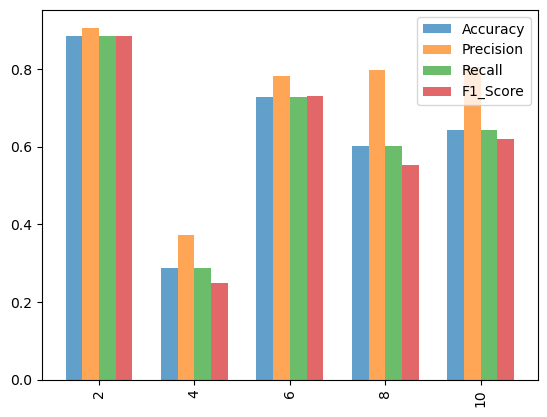

In [50]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)

In [51]:
Client_1 = (x_train[0:10000], y_train[0:10000])
Client_2 = (x_train[10000:20000], y_train[10000:20000])
Client_3 = (x_train[20000:30000], y_train[20000:30000])
Client_4 = (x_train[30000:40000], y_train[30000:40000])
Client_5 = (x_train[40000:50000], y_train[40000:50000])
Client_6 = (x_train[50000:], y_train[50000:])

In [52]:
Client_2[1].size

10000

In [53]:
Client_2[1]

array([3, 8, 7, ..., 1, 4, 2], dtype=uint8)

In [54]:

Client_2[1][:2000] = 4

In [55]:
Client_2[1]

array([4, 4, 4, ..., 1, 4, 2], dtype=uint8)

In [56]:
print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [57]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])

Epoch 1/5
313/313 [==============================] - 1s 1ms/step - loss: 0.5099 - accuracy: 0.8617
Epoch 2/5
313/313 [==============================] - 0s 2ms/step - loss: 0.2442 - accuracy: 0.9308
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1767 - accuracy: 0.9474
Epoch 4/5
313/313 [==============================] - 0s 2ms/step - loss: 0.1332 - accuracy: 0.9622
Epoch 5/5
313/313 [==============================] - 0s 2ms/step - loss: 0.1029 - accuracy: 0.9720
Epoch 1/5
313/313 [==============================] - 1s 1ms/step - loss: 2.3199 - accuracy: 0.0988
Epoch 2/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2947 - accuracy: 0.1264
Epoch 3/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2816 - accuracy: 0.1339
Epoch 4/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2639 - accuracy: 0.1529
Epoch 5/5
313/313 [==============================] - 0s 2ms/step - loss: 2.2384 - accuracy: 0.1660
Epoch 1/5


In [58]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weights1, weights2, weights3, weights4, weights5, weights6):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6) / 6)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [59]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 0s - loss: 1.9891 - accuracy: 0.7361 - 492ms/epoch - 2ms/step
Test accuracy: 0.7361000180244446
313/313 [==============================] - 0s 908us/step
(10000, 10)
Accuracy test set:  0.7361
Precision test set:  0.7414356425281612
Recall test set:  0.7361
F-score test set:  0.7093201396335478
              precision    recall  f1-score   support

           0       0.94      0.66      0.78       980
           1       0.88      0.99      0.93      1135
           2       0.70      0.74      0.72      1032
           3       0.66      0.76      0.71      1010
           4       0.62      0.96      0.76       982
           5       0.88      0.64      0.74       892
           6       0.93      0.87      0.90       958
           7       0.70      0.88      0.78      1028
           8       0.57      0.77      0.65       974
           9       0.54      0.07      0.12      1009

    accuracy                           0.74     10000
   macro avg       0.74      0.73      0.71  

In [60]:
test_accuracy_dishonest  = []
test_precision_dishonest = []
test_recall_dishonest    = []
test_f1_score_dishonest  = []

In [61]:
test_accuracy_dishonest.append(test_accuracy[2])
test_precision_dishonest.append(test_precision[2])
test_recall_dishonest.append(test_recall[2])
test_f1_score_dishonest.append(test_f1_score[2])

test_accuracy_dishonest.append(0.7197999954223633)
test_precision_dishonest.append(0.7649681801937827)
test_recall_dishonest.append(0.7198)
test_f1_score_dishonest.append(0.7079021148713025)

print(test_accuracy_dishonest)
print(test_precision_dishonest)
print(test_recall_dishonest)
print(test_f1_score_dishonest)

[0.7271999716758728, 0.7197999954223633]
[0.7834205071021751, 0.7649681801937827]
[0.7272, 0.7198]
[0.7308748558259915, 0.7079021148713025]


In [62]:
### Plot the model's performance for the 6 clients, one of them (number=2) is dishonest

ErrorMetrics = []
ErrorMetrics.append(test_accuracy_dishonest)
ErrorMetrics.append(test_precision_dishonest)
ErrorMetrics.append(test_recall_dishonest)
ErrorMetrics.append(test_f1_score_dishonest)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = ['All are honest', '#2 is dishonest']
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.7271999716758728, 0.7197999954223633], [0.7834205071021751, 0.7649681801937827], [0.7272, 0.7198], [0.7308748558259915, 0.7079021148713025]]


,Accuracy,Precision,Recall,F1_Score
All are honest,0.7272,0.783421,0.7272,0.730875
#2 is dishonest,0.7198,0.764968,0.7198,0.707902


<Axes: >

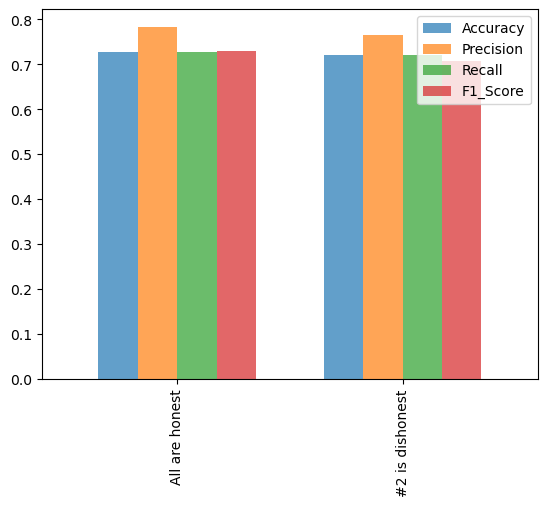

In [63]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)